In [1]:
# imports

import os
import re
import math
import json
import random
from dotenv import load_dotenv
from huggingface_hub import login
from items import Item
import matplotlib.pyplot as plt
import numpy as np
import pickle
from collections import Counter
from openai import OpenAI

In [2]:
# call it with Tester.test(function_name, test_dataset)
from testing import Tester

In [3]:
load_dotenv()
os.environ['OPENAI_API_KEY'] = os.getenv('OPENAI_API_KEY', 'your-key-if-not-using-env')
os.environ['HF_TOKEN'] = os.getenv('HF_TOKEN', 'your-key-if-not-using-env')

# Log in to HuggingFace
hf_token = os.environ['HF_TOKEN']
login(hf_token, add_to_git_credential=True)

Note: Environment variable`HF_TOKEN` is set and is the current active token independently from the token you've just configured.


In [4]:
openai = OpenAI()

In [5]:
%matplotlib inline

In [6]:
# Let's avoid curating all our data again! Load in the pickle files:

with open('train.pkl', 'rb') as file:
    train = pickle.load(file)

with open('test.pkl', 'rb') as file:
    test = pickle.load(file)

In [7]:
# OpenAI recommends fine-tuning with populations of 50-100 examples
# But as our examples are very small, I'm suggesting we go with 500 examples (and 1 epoch)

fine_tune_train = train[:500]
fine_tune_validation = train[500:550]

In [8]:
# First let's work on a good prompt for a Frontier model
# Notice that I'm removing the " to the nearest dollar"
# When we train our own models, we'll need to make the problem as easy as possible, 
# but a Frontier model needs no such simplification.

def messages_for(item):
    system_message = "You estimate prices of items. Reply only with the price, no explanation"
    user_prompt = item.test_prompt().replace(" to the nearest dollar","").replace("\n\nPrice is $","")
    return [
        {"role": "system", "content": system_message},
        {"role": "user", "content": user_prompt},
        {"role": "assistant", "content": f"Price is ${item.price:.2f}"}
    ]

In [9]:
# Convert the items into a list of json objects - a "jsonl" string
# Each row represents a message in the form:
# {"messages" : [{"role": "system", "content": "You estimate prices...


def make_jsonl(items):
    result = ""
    for item in items:
        messages = messages_for(item)
        messages_str = json.dumps(messages)
        result += '{"messages": ' + messages_str +'}\n'
    return result.strip()

In [10]:
# Convert the items into jsonl and write them to a file

def write_jsonl(items, filename):
    with open(filename, "w") as f:
        jsonl = make_jsonl(items)
        f.write(jsonl)

In [11]:
write_jsonl(fine_tune_train, "fine_tune_train.jsonl")

In [12]:
write_jsonl(fine_tune_validation, "fine_tune_validation.jsonl")

In [13]:
with open("fine_tune_train.jsonl", "rb") as f:
    train_file = openai.files.create(file=f, purpose="fine-tune")

In [14]:
train_file

FileObject(id='file-KgvdYH3jCNuCrNACXHFk9i', bytes=470870, created_at=1739921320, filename='fine_tune_train.jsonl', object='file', purpose='fine-tune', status='processed', status_details=None)

In [15]:
with open("fine_tune_validation.jsonl", "rb") as f:
    validation_file = openai.files.create(file=f, purpose="fine-tune")

In [16]:
validation_file

FileObject(id='file-Dh9ccRfeu8UYzwtBG7nXXM', bytes=47108, created_at=1739921339, filename='fine_tune_validation.jsonl', object='file', purpose='fine-tune', status='processed', status_details=None)

https://wandb.ai

From the Avatar >> Settings menu, near the bottom, you can create an API key.

Then visit the OpenAI dashboard at:

https://platform.openai.com/account/organization

In the integrations section, you can add your Weights & Biases key.

In [17]:
wandb_integration = {"type": "wandb", "wandb": {"project": "gpt-pricer"}}

In [18]:
openai.fine_tuning.jobs.create(
    training_file=train_file.id,
    validation_file=validation_file.id,
    model="gpt-4o-mini-2024-07-18",
    seed=42,
    hyperparameters={"n_epochs": 1},
    integrations = [wandb_integration],
    suffix="pricer"
)

FineTuningJob(id='ftjob-kcQx3BwsXoYZUZkvqLSjVpSh', created_at=1739921476, error=Error(code=None, message=None, param=None), fine_tuned_model=None, finished_at=None, hyperparameters=Hyperparameters(batch_size='auto', learning_rate_multiplier='auto', n_epochs=1), model='gpt-4o-mini-2024-07-18', object='fine_tuning.job', organization_id='org-1VOii4fqByltWYGWzhW7M8dW', result_files=[], seed=42, status='validating_files', trained_tokens=None, training_file='file-KgvdYH3jCNuCrNACXHFk9i', validation_file='file-Dh9ccRfeu8UYzwtBG7nXXM', estimated_finish=None, integrations=[FineTuningJobWandbIntegrationObject(type='wandb', wandb=FineTuningJobWandbIntegration(project='gpt-pricer', entity=None, name=None, tags=None, run_id='ftjob-kcQx3BwsXoYZUZkvqLSjVpSh'))], method=Method(dpo=None, supervised=MethodSupervised(hyperparameters=MethodSupervisedHyperparameters(batch_size='auto', learning_rate_multiplier='auto', n_epochs=1)), type='supervised'), user_provided_suffix='pricer')

In [19]:
openai.fine_tuning.jobs.list(limit=1)

SyncCursorPage[FineTuningJob](data=[FineTuningJob(id='ftjob-kcQx3BwsXoYZUZkvqLSjVpSh', created_at=1739921476, error=Error(code=None, message=None, param=None), fine_tuned_model=None, finished_at=None, hyperparameters=Hyperparameters(batch_size='auto', learning_rate_multiplier='auto', n_epochs=1), model='gpt-4o-mini-2024-07-18', object='fine_tuning.job', organization_id='org-1VOii4fqByltWYGWzhW7M8dW', result_files=[], seed=42, status='validating_files', trained_tokens=None, training_file='file-KgvdYH3jCNuCrNACXHFk9i', validation_file='file-Dh9ccRfeu8UYzwtBG7nXXM', estimated_finish=None, integrations=[FineTuningJobWandbIntegrationObject(type='wandb', wandb=FineTuningJobWandbIntegration(project='gpt-pricer', entity=None, name=None, tags=None, run_id='ftjob-kcQx3BwsXoYZUZkvqLSjVpSh'))], method=Method(dpo=None, supervised=MethodSupervised(hyperparameters=MethodSupervisedHyperparameters(batch_size='auto', learning_rate_multiplier='auto', n_epochs=1)), type='supervised'), user_provided_suffix

In [20]:
job_id = openai.fine_tuning.jobs.list(limit=1).data[0].id

In [21]:
job_id

'ftjob-kcQx3BwsXoYZUZkvqLSjVpSh'

In [22]:
openai.fine_tuning.jobs.retrieve(job_id)

FineTuningJob(id='ftjob-kcQx3BwsXoYZUZkvqLSjVpSh', created_at=1739921476, error=Error(code=None, message=None, param=None), fine_tuned_model=None, finished_at=None, hyperparameters=Hyperparameters(batch_size='auto', learning_rate_multiplier='auto', n_epochs=1), model='gpt-4o-mini-2024-07-18', object='fine_tuning.job', organization_id='org-1VOii4fqByltWYGWzhW7M8dW', result_files=[], seed=42, status='validating_files', trained_tokens=None, training_file='file-KgvdYH3jCNuCrNACXHFk9i', validation_file='file-Dh9ccRfeu8UYzwtBG7nXXM', estimated_finish=None, integrations=[FineTuningJobWandbIntegrationObject(type='wandb', wandb=FineTuningJobWandbIntegration(project='gpt-pricer', entity=None, name=None, tags=None, run_id='ftjob-kcQx3BwsXoYZUZkvqLSjVpSh'))], method=Method(dpo=None, supervised=MethodSupervised(hyperparameters=MethodSupervisedHyperparameters(batch_size='auto', learning_rate_multiplier='auto', n_epochs=1)), type='supervised'), user_provided_suffix='pricer')

In [28]:
## It will take sometime approx 10-15 mins wait for it
openai.fine_tuning.jobs.list_events(fine_tuning_job_id=job_id, limit=10).data

[FineTuningJobEvent(id='ftevent-OrDJUPM9UUGC0lXBzB4ifVav', created_at=1739922479, level='info', message='The job has successfully completed', object='fine_tuning.job.event', data={}, type='message'),
 FineTuningJobEvent(id='ftevent-5eHJ9seLYg5y9fysMsm3RzyM', created_at=1739922472, level='info', message='New fine-tuned model created', object='fine_tuning.job.event', data={}, type='message'),
 FineTuningJobEvent(id='ftevent-ukAHgLstyeus5XlXtvfIvuhr', created_at=1739922412, level='info', message='Step 500/500: training loss=1.08, validation loss=1.77, full validation loss=1.12', object='fine_tuning.job.event', data={'step': 500, 'train_loss': 1.0829026699066162, 'valid_loss': 1.7663359642028809, 'total_steps': 500, 'full_valid_loss': 1.1241084384918212, 'train_mean_token_accuracy': 0.75, 'valid_mean_token_accuracy': 0.75, 'full_valid_mean_token_accuracy': 0.8}, type='metrics'),
 FineTuningJobEvent(id='ftevent-04q12xmvzfSoiaoeNcST83HD', created_at=1739922402, level='info', message='Step 49

In [29]:
## Now it's time to test our finetuned model
fine_tuned_model_name = openai.fine_tuning.jobs.retrieve(job_id).fine_tuned_model

In [30]:
# The prompt

def messages_for(item):
    system_message = "You estimate prices of items. Reply only with the price, no explanation"
    user_prompt = item.test_prompt().replace(" to the nearest dollar","").replace("\n\nPrice is $","")
    return [
        {"role": "system", "content": system_message},
        {"role": "user", "content": user_prompt},
        {"role": "assistant", "content": "Price is $"}
    ]

In [31]:
messages_for(test[0])

[{'role': 'system',
  'content': 'You estimate prices of items. Reply only with the price, no explanation'},
 {'role': 'user',
  'content': "How much does this cost?\n\nOEM AC Compressor w/A/C Repair Kit For Ford F150 F-150 V8 & Lincoln Mark LT 2007 2008 - BuyAutoParts NEW\nAs one of the world's largest automotive parts suppliers, our parts are trusted every day by mechanics and vehicle owners worldwide. This A/C Compressor and Components Kit is manufactured and tested to the strictest OE standards for unparalleled performance. Built for trouble-free ownership and 100% visually inspected and quality tested, this A/C Compressor and Components Kit is backed by our 100% satisfaction guarantee. Guaranteed Exact Fit for easy installation 100% BRAND NEW, premium ISO/TS 16949 quality - tested to meet or exceed OEM specifications Engineered for superior durability, backed by industry-leading unlimited-mileage warranty Included in this K"},
 {'role': 'assistant', 'content': 'Price is $'}]

In [32]:
# A utility function to extract the price from a string

def get_price(s):
    s = s.replace('$','').replace(',','')
    match = re.search(r"[-+]?\d*\.\d+|\d+", s)
    return float(match.group()) if match else 0

In [33]:
get_price("The price is roughly $99.99 because blah blah")

99.99

In [34]:
# The function for gpt-4o-mini

def gpt_fine_tuned(item):
    response = openai.chat.completions.create(
        model=fine_tuned_model_name, 
        messages=messages_for(item),
        seed=42,
        max_tokens=7
    )
    reply = response.choices[0].message.content
    return get_price(reply)

In [35]:
print(test[0].price)
print(gpt_fine_tuned(test[0]))

374.41
174.77


1: Guess: $174.77 Truth: $374.41 Error: $199.64 SLE: 0.58 Item: OEM AC Compressor w/A/C Repair Kit For F...
2: Guess: $76.47 Truth: $225.11 Error: $148.64 SLE: 1.15 Item: Motorcraft YB3125 Fan Clutch
3: Guess: $65.65 Truth: $61.68 Error: $3.97 SLE: 0.00 Item: Dorman 603-159 Front Washer Fluid Reserv...
4: Guess: $277.65 Truth: $599.99 Error: $322.34 SLE: 0.59 Item: HP Premium 17.3-inch HD Plus Touchscreen...
5: Guess: $14.98 Truth: $16.99 Error: $2.01 SLE: 0.01 Item: 5-Position Super Switch Pickup Selector ...
6: Guess: $13.66 Truth: $31.99 Error: $18.33 SLE: 0.66 Item: Horror Bookmarks, Resin Horror Bookmarks...
7: Guess: $139.98 Truth: $101.79 Error: $38.19 SLE: 0.10 Item: SK6241 - Stinger 4 Gauge 6000 Series Pow...
8: Guess: $262.47 Truth: $289.00 Error: $26.53 SLE: 0.01 Item: Godox ML60Bi LED Light Kit, Handheld LED...
9: Guess: $499.99 Truth: $635.86 Error: $135.87 SLE: 0.06 Item: Randall RG75DG3PLUS G3 Plus 100-Watt Com...
10: Guess: $47.99 Truth: $65.99 Error: $18.00 SLE: 0.10 I

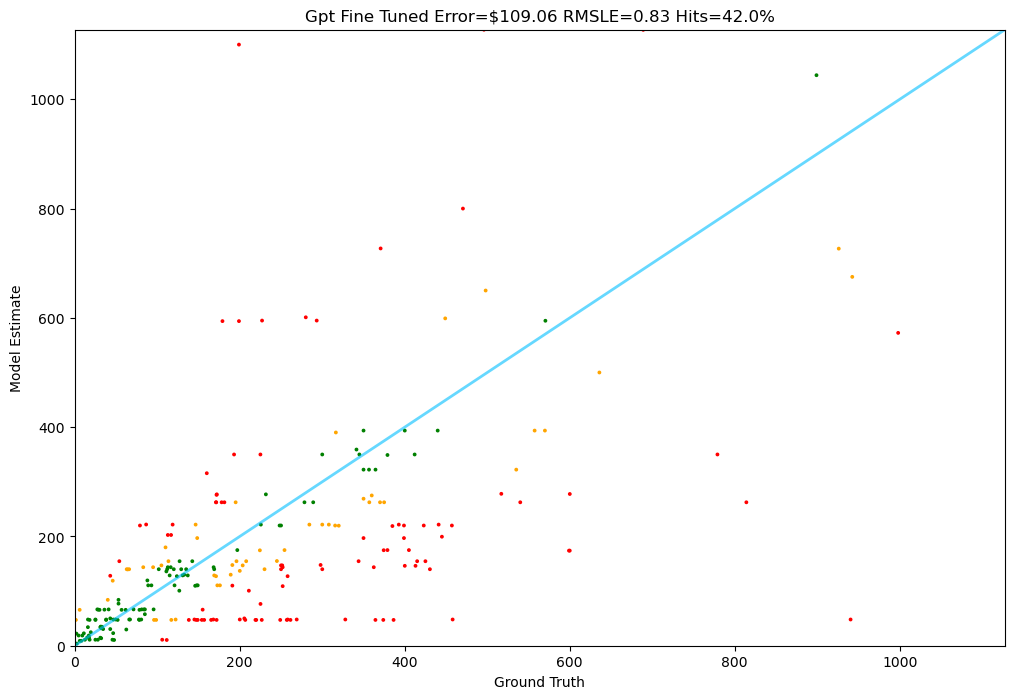

In [36]:
Tester.test(gpt_fine_tuned, test)